In [3]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
import csv

%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "47b05e70-6076-44e8-96da-2530dc2187de_data_train.csv"
path_submission = "9b4d32bb-f99a-466f-95a1-0ab80048971c_sample_submission (2).csv"
ratings = load_data(path_dataset)
submission = load_submission(path_submission)
submission_row_col = submission[0]
submission_pos = submission[1]
print(ratings.shape)
print(submission_pos[0])
print(submission_row_col[0])

number of items: 10000, number of users: 1000
(10000, 1000)
r37_c1
(37, 1)


### Plot the number of ratings per movie and user

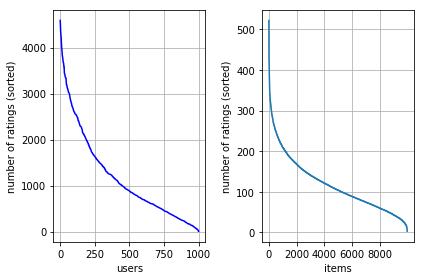

min # of items per user = 8, min # of users per item = 3.


In [38]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

### Split the data into a train and test set

In [ ]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [43]:
from plots import plot_train_test_data

valid_ratings = read_in_train_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0)
#plot_train_test_data(train, test)

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (9648, 996)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:0


# Inplementation of GMM

## Functions for E-step

In [ ]:
def likelihood(user,center,cov):
    right_factor = np.linalg.solve(cov,(user-center))
    return np.exp(-1/2*(user-center).T @ right_factor)

In [ ]:
def marginal_likelihood(data_mat, center_mat, cov_mat, pi_vec):
    loss = 0
    K = center_mat.shape[1]
    num_user = data_mat.shape[1]
    for n in range(num_user):
        for k in range(K):
            individual_likelihood = 0
            individual_likelihood += pi_vec[k] * likelihood(data_mat[:,n],center_mat[:,k],cov_mat[k,:,:])
        loss += individual_likelihood
    return loss

In [ ]:
def compute_q(data_mat, center_mat, cov_mat, pi_vec):
    num_user = data_mat.shape[1]
    K = center_mat.shape[1]
    Q = np.zeros(num_user,K)
    likelihood_vec = np.zeros(K)
    for n in range(num_user):
        denominator = 0
        for k in range(K):
            likelihood_vec[k] = likelihood(data_mat[:,n],center_mat[:,k],cov_mat[k,:,:])
            denominator += pi_vec[k] * likelihood_vec[k]
            
        for k in range(K):
            Q[n,k] = pi_vec[k] * likelihood_vec[k] / denominator
    return Q

## Functions for M-step

In [ ]:
def update_center(Q,data_mat):
    num_item = data_mat.shape[0]
    num_user = data_mat.shape[1]
    K = center_mat.shape[1]
    center_mat = np.zeros(num_user,K)
    for k in range(K):
        numerator = np.zeros(num_item)
        for n in range(num_user):
            numerator += Q[n,k] * data_mat[:,n]
        center_mat[:,k] = numerator / sum(Q[:,k])
    return center_mat

In [ ]:
def update_cov(center_mat,Q,data_mat):
    num_item = data_mat.shape[0]
    num_user = data_mat.shape[1]
    K = center_mat.shape[1]
    cov_mat = np.zeros(K,num_user,num_user)
    for k in range(K):
        numerator = np.zeros(num_user,num_user)
        for n in range(num_user):
            diff = data_mat[:,n] - center_mat[:,k]
            numerator += Q[n,k] * diff @ diff.T
        cov_mat[k,:,:] = numerator / sum(Q[:,k])
    return cov_mat

In [ ]:
def update_p(Q):
    K = Q.shape[1]
    num_user = Q.shape[0]
    pi_vec = np.zeros(K)
    for k in range(K):
        pi_vec[k] = 1/num_user * sum(Q[:,k])
    return pi_vec

## GMM Iteration

In [ ]:
def GMM_iteration(K):
    

In [5]:
a = np.array([1,2,3,0])
print(a[a.nonzero()])

[1 2 3]
